In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , FunctionTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score

In [2]:
df = pd.read_csv("data/data_clean.csv")
df = df.drop("Unnamed: 0",axis=1)
df.head()

,funder,gps_height,installer,wpt_name,basin,region_code,district_code,population,public_meeting,permit,extraction_type_class,management,payment_type,quality_group,quantity,source,source_class,waterpoint_type,status_group,construction_year_bins
0,other,1390,other,none,Lake Nyasa,11,5,109,1.0,0.0,gravity,vwc,annually,good,enough,spring,groundwater,communal standpipe,functional,"(1990.0, 2000.0]"
1,other,1399,other,Zahanati,Lake Victoria,20,2,280,NaN,1.0,gravity,wug,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,"(2000.0, 2010.0]"
2,other,686,other,other,Pangani,21,4,250,1.0,1.0,gravity,vwc,per bucket,good,enough,dam,surface,communal standpipe multiple,functional,"(2000.0, 2010.0]"
3,other,263,other,other,Ruvuma / Southern Coast,90,63,58,1.0,1.0,submersible,vwc,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional,"(1980.0, 1990.0]"
4,other,0,other,Shuleni,Lake Victoria,18,1,0,1.0,1.0,gravity,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,"(1980.0, 1990.0]"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   funder                  59400 non-null  object 
 1   gps_height              59400 non-null  int64  
 2   installer               59400 non-null  object 
 3   wpt_name                59400 non-null  object 
 4   basin                   59400 non-null  object 
 5   region_code             59400 non-null  int64  
 6   district_code           59400 non-null  int64  
 7   population              59400 non-null  int64  
 8   public_meeting          56066 non-null  float64
 9   permit                  56344 non-null  float64
 10  extraction_type_class   59400 non-null  object 
 11  management              59400 non-null  object 
 12  payment_type            59400 non-null  object 
 13  quality_group           59400 non-null  object 
 14  quantity                59400 non-null

In [4]:
def int_to_object(df):
    df["region_code"] = df["region_code"].astype(object)
    df["district_code"] = df["district_code"].astype(object)
    df["public_meeting"] = df["public_meeting"].astype(str)
    df["permit"] = df["permit"].astype(str)
    df["construction_year_bins"] = df["construction_year_bins"].astype(str)
    return df.dtypes

In [5]:
int_to_object(df)

funder                    object
gps_height                 int64
installer                 object
wpt_name                  object
basin                     object
region_code               object
district_code             object
population                 int64
public_meeting            object
permit                    object
extraction_type_class     object
management                object
payment_type              object
quality_group             object
quantity                  object
source                    object
source_class              object
waterpoint_type           object
status_group              object
construction_year_bins    object
dtype: object

In [6]:
X = df.drop('status_group', axis=1)
y = df['status_group']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [8]:
map_dict = {"functional": 1, "non functional": 2, "functional needs repair": 3}
y_train = y_train.map(map_dict)
y_test = y_test.map(map_dict)

In [9]:
y_train.value_counts()

1    24161
2    17146
3     3243
Name: status_group, dtype: int64

In [10]:
def grab_numeric(df):
    return df.select_dtypes(include=['int64'])

In [11]:
GrabNumeric = FunctionTransformer(grab_numeric)

In [12]:
pipe= Pipeline(steps=[("num", GrabNumeric),
                      ( "ss", StandardScaler())])

In [13]:
pipe.fit(X_train)

Pipeline(steps=[('num',
                 FunctionTransformer(func=<function grab_numeric at 0x1331ad550>)),
                ('ss', StandardScaler())])

In [14]:
pipe.transform(X_train)

array([[-0.48786917, -0.20973197],
       [-0.96404191, -0.37956688],
       [-0.96404191, -0.37956688],
       ...,
       [-0.98280023,  1.74336955],
       [-0.96404191, -0.37956688],
       [ 0.89736062, -0.37744395]])

In [15]:
j = -1
for i in X_train.columns:
    j+=1
    print("Index Number", j,i)

Index Number 0 funder
Index Number 1 gps_height
Index Number 2 installer
Index Number 3 wpt_name
Index Number 4 basin
Index Number 5 region_code
Index Number 6 district_code
Index Number 7 population
Index Number 8 public_meeting
Index Number 9 permit
Index Number 10 extraction_type_class
Index Number 11 management
Index Number 12 payment_type
Index Number 13 quality_group
Index Number 14 quantity
Index Number 15 source
Index Number 16 source_class
Index Number 17 waterpoint_type
Index Number 18 construction_year_bins


In [16]:
# We'll throw these mini-pipelines into our ColumnTransformer.

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer(strategy="median")),
                           ('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='constant')),
                             ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])


In [17]:
CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [1,7]),
                                         ('subpipe_cat', subpipe_cat, [0,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18])])

In [18]:
dt_model_pipe = Pipeline(steps=([("ct", CT), 
                                    ("dt", DecisionTreeClassifier(random_state = 0))]))
dt_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [1, 7]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                               

In [19]:
dt_grid = [{'dt__max_depth': [2, 4, 6], 
         'dt__min_samples_leaf': [20, 25]}]


gridsearch = GridSearchCV(estimator=dt_model_pipe, 
                          param_grid=dt_grid, 
                          scoring='accuracy', 
                          cv=5)

gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [1,
                                                                          7]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                               

In [20]:
gridsearch.score(X_test, y_test)

0.7214141414141414

In [21]:
gridsearch.best_params_

{'dt__max_depth': 6, 'dt__min_samples_leaf': 20}

In [22]:
gridsearch.cv_results_['mean_test_score']

array([0.6935578 , 0.6935578 , 0.70190797, 0.70190797, 0.71946128,
       0.71928171])

In [23]:
t_predict= dt_model_pipe.predict(X_train)
t_test_predict = dt_model_pipe.predict(X_test)

print('Training Precision: ', precision_score(y_train, t_predict, average='macro'))
print('Testing Precision: ', precision_score(y_test, t_test_predict, average='macro'))
print('\n\n')

print('Training Recall: ', recall_score(y_train, t_predict, average='macro'))
print('Testing Recall: ', recall_score(y_test, t_test_predict, average='macro'))

Training Precision:  0.9400839244220239
Testing Precision:  0.6420928096648822



Training Recall:  0.8983780469568533
Testing Recall:  0.6312087033294892


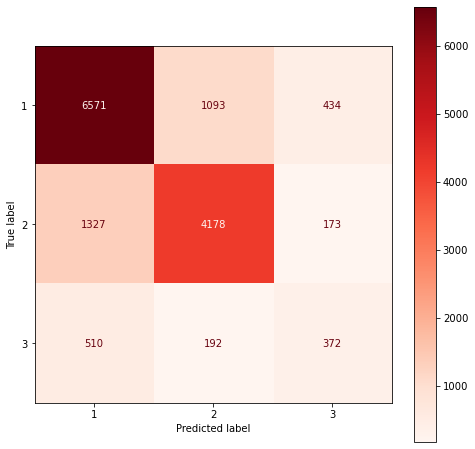

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(dt_model_pipe, X_test, y_test, cmap=plt.cm.Reds, ax=ax);

In [43]:
def model_evaluation(model, X_train, y_train, X_test, y_test):
    print(f"""
    Training Accuracy Score: {round(accuracy_score(y_train, model.predict(X_train)),2)} 
    Testing Accuracy Score: {round(accuracy_score(y_test, model.predict(X_test)),2)}
    
    Training Precision Score: {round(precision_score(y_train, model.predict(X_train), average= 'macro'),2)}
    Testing Precision Score: {round(precision_score(y_test, model.predict(X_test), average= 'macro'),2)} 
    
    Training Recall Score: {round(recall_score(y_train, model.predict(X_train), average= 'macro'),2)}
    Testing Recall Score: {round(recall_score(y_test, model.predict(X_test), average= 'macro'),2)} 
    
    Training F1 Score: {round(f1_score(y_train, model.predict(X_train), average= 'macro'),2)}
    Testing F1 Score: {round(f1_score(y_test, model.predict(X_test), average= 'macro'),2)} 
    
    Confusion Matrix:""")     
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(model, X_test, y_test, normalize = 'true', display_labels = ['Functional', 'Functional Needs Repair', 'Nonfunctional'],ax=ax)                        
                                 
                                 


    Training Accuracy Score: 0.95 
    Testing Accuracy Score: 0.75
    
    Training Precision Score: 0.94
    Testing Precision Score: 0.64 
    
    Training Recall Score: 0.9
    Testing Recall Score: 0.63 
    
    Training F1 Score: 0.92
    Testing F1 Score: 0.64 
    
    Confusion Matrix:


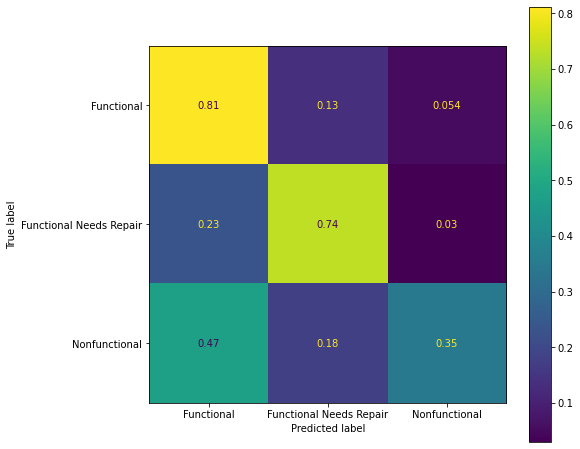

In [44]:
model_evaluation(dt_model_pipe, X_train, y_train, X_test, y_test)

In [ ]:
Training ROC_AUC: {round(roc_auc_score(y_train, model.predict(X_train), average= 'macro'),2)}
Testing ROC_AUC:  {round(roc_auc_score(y_test, model.predict(X_test), average= 'macro'),2)} \